<a href="https://www.kaggle.com/code/srishtipriya2108/capstone-23mcb0032?scriptVersionId=201711119" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import time
import random

import torch
import torchvision

from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam

from torchvision import transforms, datasets
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from timeit import default_timer as timer
from typing import Dict, List

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
!pip install torchsummary

import torch
import torchvision.models as models
from torchsummary import summary

In [4]:
try:
    from torchinfo import summary
    print("[INFO] torchinfo imported successfully")
except:
    print("[INFO] Could not find torchinfo. Installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
    print("[INFO] torchinfo installed and imported successfully.")

[INFO] torchinfo imported successfully


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
#For ImageNet-1K, the commonly used mean values for each color channel (RGB) are:

#Mean for Red channel (R): 0.485
#Mean for Green channel (G): 0.456
#Mean for Blue channel (B): 0.406

In [7]:
dataset_dir = Path("/kaggle/input/new-plant-diseases-dataset")

print(dataset_dir)

/kaggle/input/new-plant-diseases-dataset


In [8]:
train_dir = dataset_dir / "train"
val_dir = dataset_dir / "valid"
test_dir = Path("/kaggle/input/new-plant-diseases-dataset/test/test")

print(f"Train Directory : {train_dir}")
print(f"Validation Directory : {val_dir}")
print(f"Test Directory : {test_dir}")

Train Directory : /kaggle/input/new-plant-diseases-dataset/train
Validation Directory : /kaggle/input/new-plant-diseases-dataset/valid
Test Directory : /kaggle/input/new-plant-diseases-dataset/test/test


In [9]:
import os
from pathlib import Path

# Set the path to your dataset directory
dataset_dir = Path("/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)")

# Define the train, validation, and test directories
train_dir = dataset_dir / "train"
val_dir = dataset_dir / "valid"
test_dir = Path("/kaggle/input/new-plant-diseases-dataset/test/test")  # Adjust this path if necessary

# Count the number of classes in train and validation directories
total_class_train = len(os.listdir(train_dir))
total_class_val = len(os.listdir(val_dir))

# Count the number of images in the test directory
total_test = len(os.listdir(test_dir))

# Print the results
print(f"Total of Train Data Classes: {total_class_train} classes")
print(f"Total of Validation Data Classes: {total_class_val} classes")
print(f"Total of Test Data: {total_test} images")


Total of Train Data Classes: 38 classes
Total of Validation Data Classes: 38 classes
Total of Test Data: 33 images


In [10]:
def count_data_per_class(path):
    classes = sorted(os.listdir(path))
    class_counts = {}
    for cls in classes:
        class_path = os.path.join(path, cls)
        class_counts[cls] = len(os.listdir(class_path))
    return class_counts

train_class_counts = count_data_per_class(train_dir)
val_class_counts = count_data_per_class(val_dir)

train_counts_df = pd.DataFrame.from_dict(train_class_counts, orient="index", columns=["Count"])
val_counts_df = pd.DataFrame.from_dict(val_class_counts, orient="index", columns=["Count"])

In [11]:
print(f"Total Image for Training: {sum(train_class_counts.values())} images")
print(f"Total Image for Validation: {sum(val_class_counts.values())} images")

Total Image for Training: 70295 images
Total Image for Validation: 17572 images


In [12]:
train_counts_df

,Count
Apple___Apple_scab,2016
Apple___Black_rot,1987
Apple___Cedar_apple_rust,1760
Apple___healthy,2008
Blueberry___healthy,1816
Cherry_(including_sour)___Powdery_mildew,1683
Cherry_(including_sour)___healthy,1826
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,1642
Corn_(maize)___Common_rust_,1907
Corn_(maize)___Northern_Leaf_Blight,1908


In [13]:
val_counts_df

,Count
Apple___Apple_scab,504
Apple___Black_rot,497
Apple___Cedar_apple_rust,440
Apple___healthy,502
Blueberry___healthy,454
Cherry_(including_sour)___Powdery_mildew,421
Cherry_(including_sour)___healthy,456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,410
Corn_(maize)___Common_rust_,477
Corn_(maize)___Northern_Leaf_Blight,477


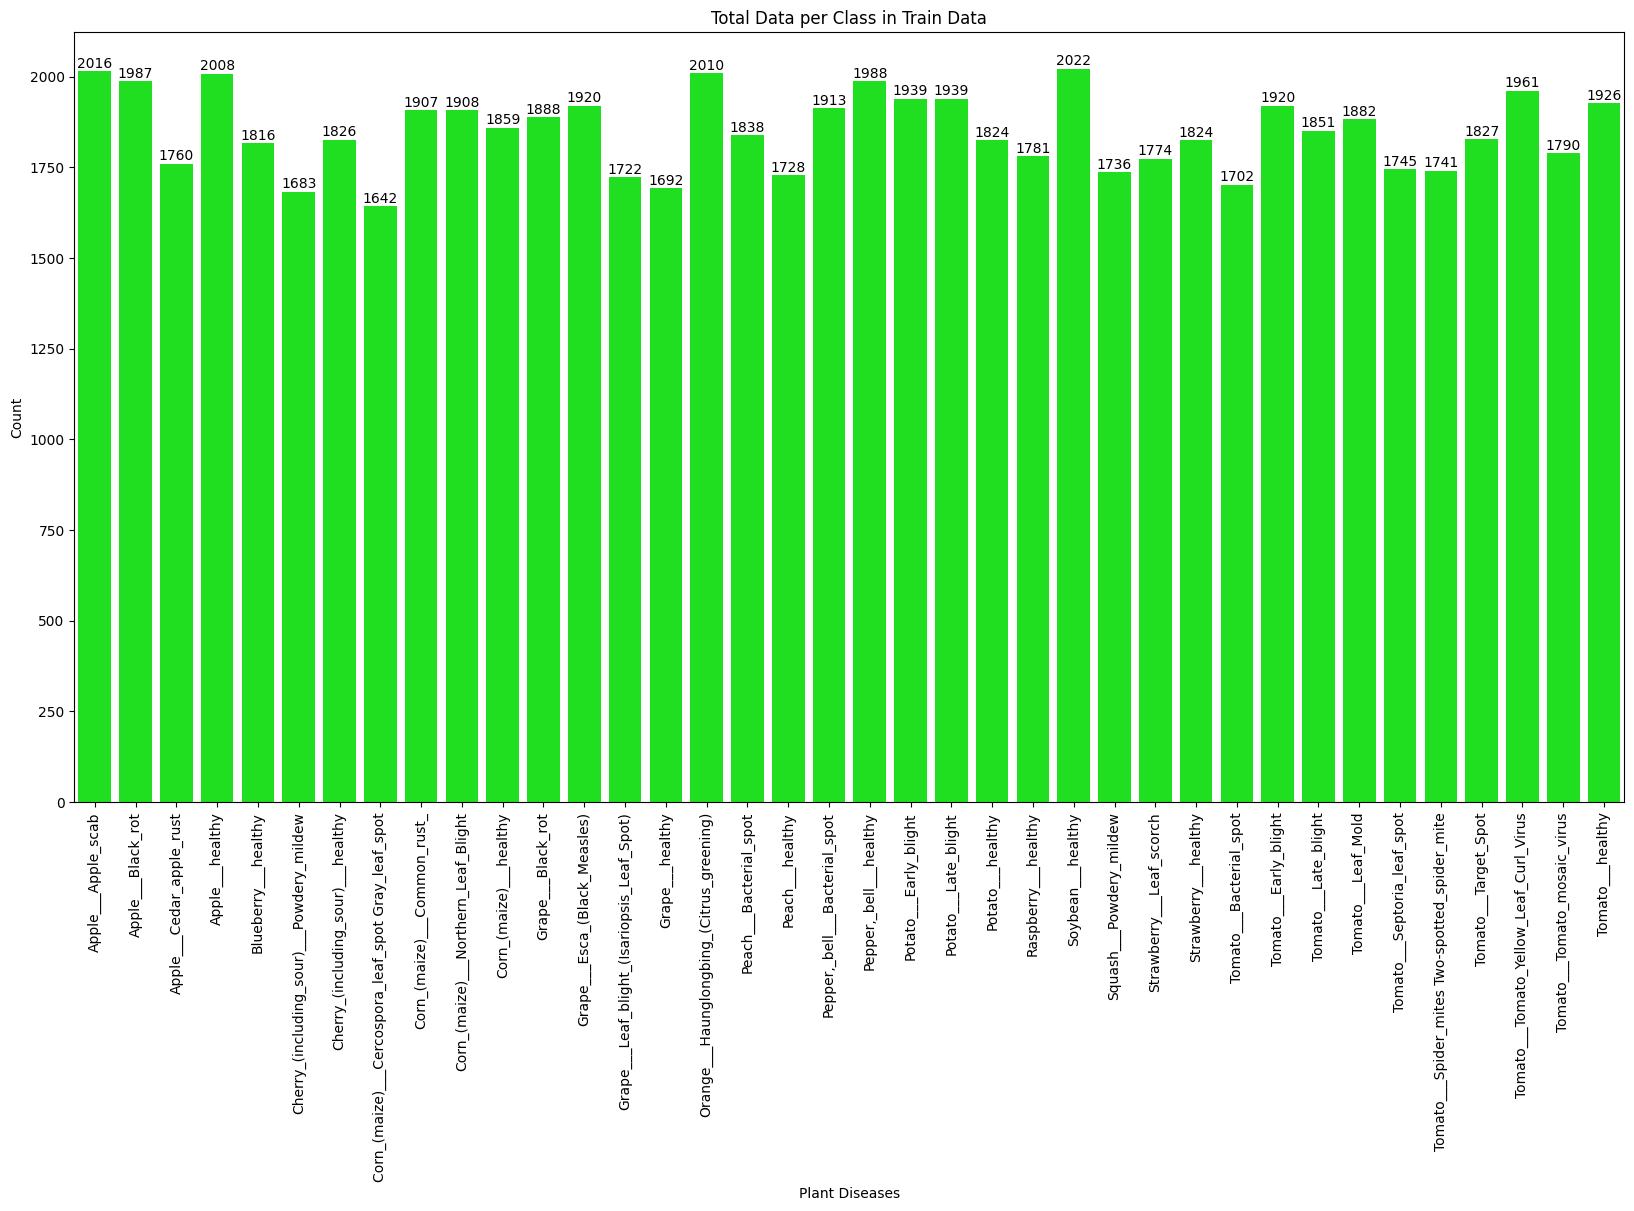

In [14]:
plt.figure(figsize=(20, 10))
sns.barplot(data=train_counts_df, x=train_counts_df.index, y="Count", color="lime")
plt.title("Total Data per Class in Train Data")
plt.xlabel("Plant Diseases")
plt.ylabel("Count")
plt.xticks(rotation=90)

ax = plt.gca()

for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2., # the count label position is center of each bar (x-coordinate)
            p.get_height()+10, # the count label offset of each bar (y-coordinate)
            '{:1.0f}'.format(p.get_height()), # get number of each bar height as count label
            ha="center") # the orientation of count label text is center horizontal

# saving plot
plt.savefig("Total Data per Class in Train Data.jpg")

# show the plot
plt.show()

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set path to dataset directory
dataset_dir = '/kaggle/input/new-plant-diseases-dataset'

# Create a dictionary to store class names and their image counts
class_counts = {}

# Iterate over the directories in the dataset and count the images
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        # Count the number of image files in the class directory
        num_images = len([file for file in os.listdir(class_path) if file.endswith('.jpg')])
        class_counts[class_name] = num_images

# Convert the dictionary into a DataFrame for easier visualization
class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

# Sort the DataFrame by the count of images
class_counts_df = class_counts_df.sort_values(by='Count', ascending=False)


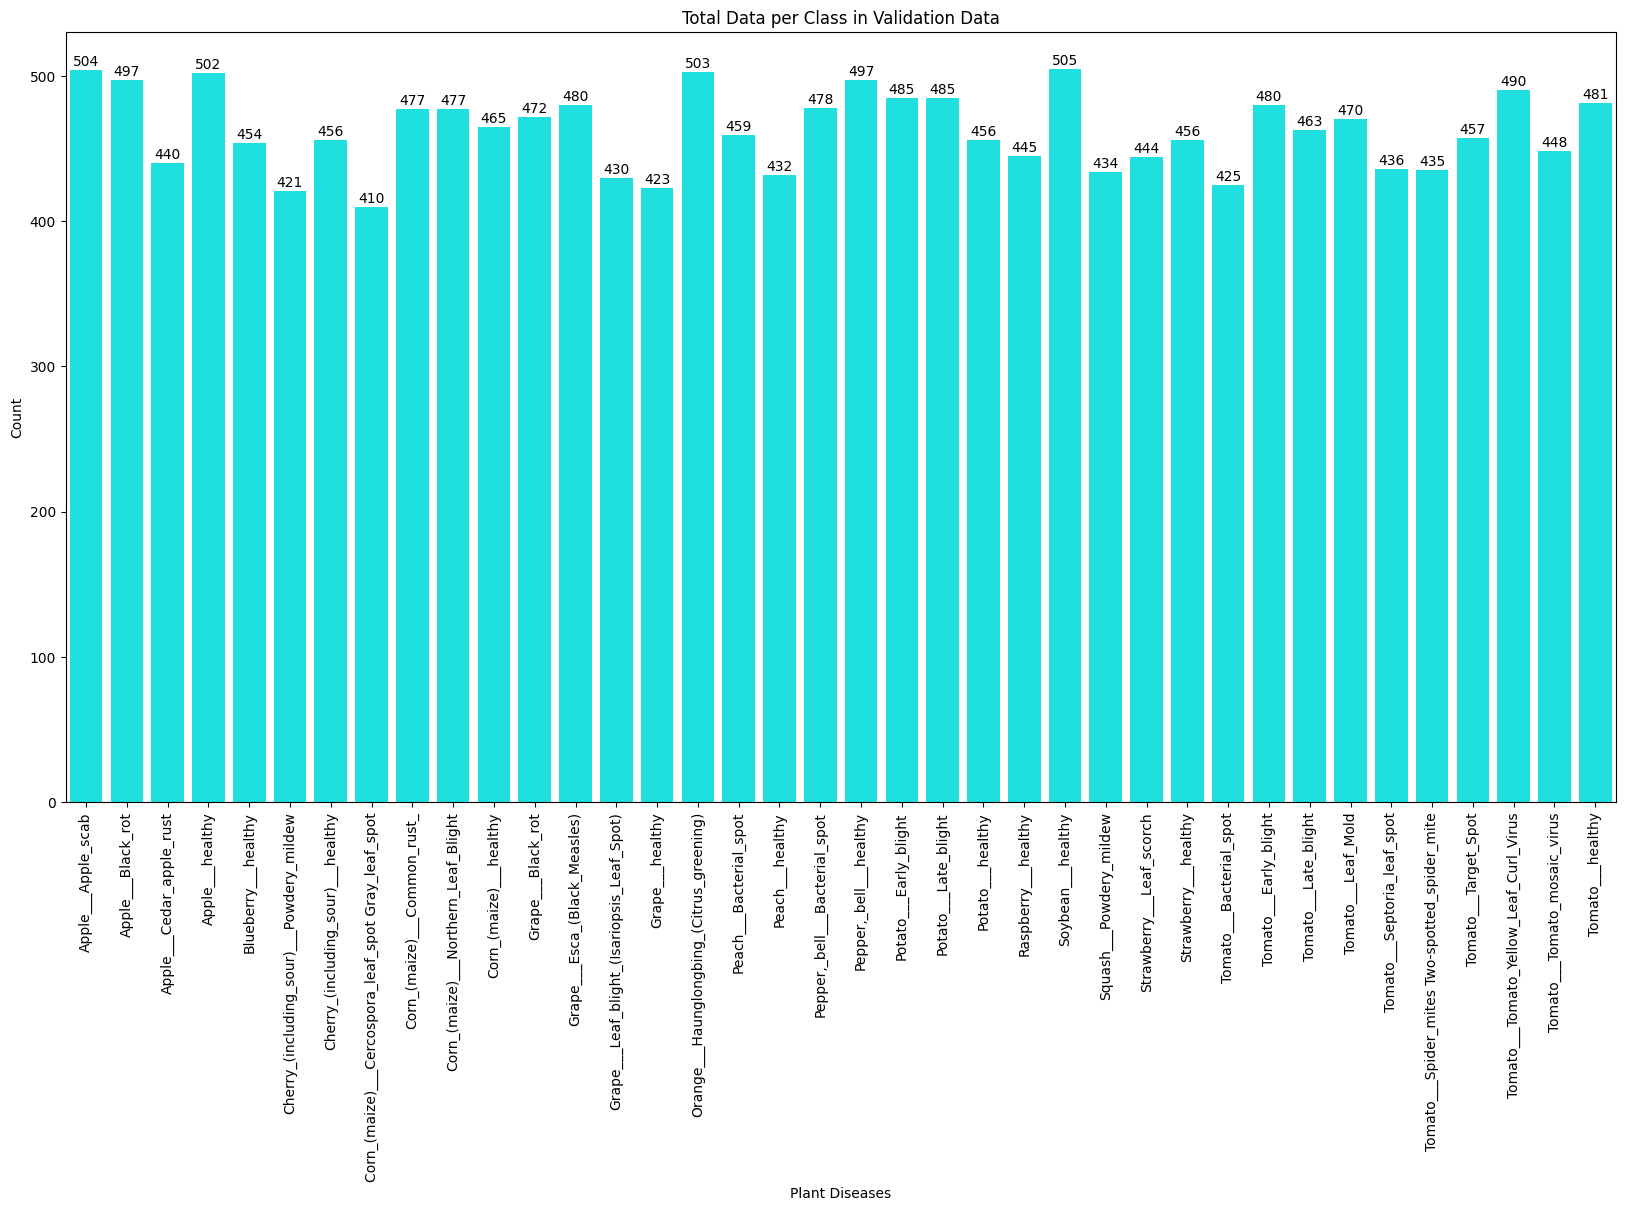

In [16]:

plt.figure(figsize=(20, 10))
sns.barplot(data=val_counts_df, x=val_counts_df.index, y="Count", color="cyan")
plt.title("Total Data per Class in Validation Data")
plt.xlabel("Plant Diseases")
plt.ylabel("Count")
plt.xticks(rotation=90)


ax = plt.gca()


for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2., # the count label position is center of each bar (x-coordinate)
            p.get_height()+3, # the count label offset of each bar (y-coordinate)
            '{:1.0f}'.format(p.get_height()), # get number of each bar height as count label
            ha="center") # the orientation of count label text is center horizontal


plt.savefig("Total Data per Class in Validation Data.jpg")


plt.show()

In [17]:
import os

# Set the path to the Kaggle dataset directory (adjust as needed)
dataset_dir = '/kaggle/input/new-plant-disease-dataset/new_plant_diseases_dataset/valid'

# List contents of the dataset directory
for root, dirs, files in os.walk(dataset_dir):
    print(f"Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {files}")
    print()  # Print a new line for better readability


In [18]:

all_diseases = sorted(os.listdir(train_dir))

plants = []
for cls in all_diseases:
    plant = cls.split("___")[0]
    if plant not in plants:
        plants.append(plant)

num_plants = len(plants)
print(f"Number of Plants: {num_plants} plants")
print("Kind of Plants: ")
for i, plant in enumerate(plants):
    print(f"{i+1}. {plant}")

diseases = []
for cls in all_diseases:
    disease = cls.split("___")[1]
    if disease not in diseases:
        if disease != "healthy":
            diseases.append(disease)
    
num_diseases = len(diseases)
print(f"\nNumber of Diseases: {num_diseases} diseases")
print("Kind of Diseases: ")
for i, disease in enumerate(diseases):
    print(f"{i+1}. {disease}")

Number of Plants: 14 plants
Kind of Plants: 
1. Apple
2. Blueberry
3. Cherry_(including_sour)
4. Corn_(maize)
5. Grape
6. Orange
7. Peach
8. Pepper,_bell
9. Potato
10. Raspberry
11. Soybean
12. Squash
13. Strawberry
14. Tomato

Number of Diseases: 20 diseases
Kind of Diseases: 
1. Apple_scab
2. Black_rot
3. Cedar_apple_rust
4. Powdery_mildew
5. Cercospora_leaf_spot Gray_leaf_spot
6. Common_rust_
7. Northern_Leaf_Blight
8. Esca_(Black_Measles)
9. Leaf_blight_(Isariopsis_Leaf_Spot)
10. Haunglongbing_(Citrus_greening)
11. Bacterial_spot
12. Early_blight
13. Late_blight
14. Leaf_scorch
15. Leaf_Mold
16. Septoria_leaf_spot
17. Spider_mites Two-spotted_spider_mite
18. Target_Spot
19. Tomato_Yellow_Leaf_Curl_Virus
20. Tomato_mosaic_virus


In [ ]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

# Set the path to your dataset directory
dataset_dir = Path("/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)")

# Get all image paths
image_path_list = list(dataset_dir.glob("*/*/*.jpg"))

# Print the number of images found
print(f"Number of images found: {len(image_path_list)}")

# Ensure there are enough images to sample from
num_images_to_sample = min(len(image_path_list), 20)  # Use the smaller of 20 or available images

# Sample images randomly
random_image_paths = random.sample(image_path_list, num_images_to_sample)

# Define the subplot for displaying images
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 40))

# Display the images
for i, ax in enumerate(axes.flat):
    if i < num_images_to_sample:
        random_image_path = random_image_paths[i]
        image_class = random_image_path.parent.stem
        image = Image.open(random_image_path)
        ax.imshow(image)
        ax.set_title(f"Label: {image_class}")
        ax.axis("off")
    else:
        ax.axis("off")  # Turn off the axis for any unused subplot

plt.tight_layout()
plt.show()


Number of images found: 3046


In [ ]:
train_transform_rn50 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.RandomRotation(45), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform_rn50 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_transform_ev2 = transforms.Compose([
    transforms.Resize(size=384, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=384),
    transforms.RandomRotation(45), # augmentation: random rotation 45 degree
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform_ev2 = transforms.Compose([
    transforms.Resize(size=384, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=384),
    # do not augment in validation data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset_rn50 = datasets.ImageFolder(root=train_dir, transform=train_transform_rn50)
val_dataset_rn50 = datasets.ImageFolder(root=val_dir, transform=val_transform_rn50)


train_dataset_ev2 = datasets.ImageFolder(root=train_dir, transform=train_transform_ev2)
val_dataset_ev2 = datasets.ImageFolder(root=val_dir, transform=val_transform_ev2)


print(f"Dataset Classes: {len(train_dataset_ev2.classes)}\n")
train_dataset_ev2.classes

In [ ]:
train_dataloader_rn50 = DataLoader(train_dataset_rn50,
                                   batch_size=32,
                                   num_workers=2,
                                   shuffle=True)

val_dataloader_rn50 = DataLoader(val_dataset_rn50,
                                 batch_size=32,
                                 num_workers=2,
                                 shuffle=False) # do not shuffle on validation data

train_dataloader_ev2 = DataLoader(train_dataset_ev2,
                                  batch_size=32,
                                  num_workers=2,
                                  shuffle=True)

val_dataloader_ev2 = DataLoader(val_dataset_ev2,
                                batch_size=32,
                                num_workers=2,
                                shuffle=False) # do not shuffle on validation data


print(f"Number of Train Dataloader: {len(train_dataloader_ev2)} batches")
print(f"Number of Validation Dataloader: {len(val_dataloader_ev2)} batches")

In [ ]:

images, labels = next(iter(train_dataloader_rn50))


num_batches = len(train_dataloader_rn50)

# print out the summary
print("[DATALOADER FOR RESNET50 MODEL]\n")
print(f"Train Dataloader = {train_dataloader_rn50}\n")
print(f"Batch Sample:\nImage Shape = {images.shape}\nLabel Shape = {labels.shape}\nLabels = {labels.tolist()}")
print(f"Number of Batches = {num_batches} batches")
print(f"Number of All Data = {32*num_batches} images")

In [ ]:
images, labels = next(iter(train_dataloader_ev2))

num_batches = len(train_dataloader_ev2)

print("[DATALOADER FOR EFFICIENTNET V2 MODEL]\n")
print(f"Train Dataloader = {train_dataloader_ev2}\n")
print(f"Batch Sample:\nImage Shape = {images.shape}\nLabel Shape = {labels.shape}\nLabels = {labels.tolist()}")
print(f"Number of Batches = {num_batches} batches")
print(f"Number of All Data = {32*num_batches} images")

In [ ]:
torch.manual_seed(33)

batch_images, batch_labels = next(iter(train_dataloader_rn50))

def display_images(images, labels, class_names, nrows=5, ncols=2):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 20))
    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - np.min(img)) / (np.max(img) - np.min(img)) 
        ax.imshow(img)

        label_idx = labels[i].item()
        class_name = class_names[label_idx]
    
        ax.set_title(f"Label: {class_name}\nShape: {img.shape}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

display_images(batch_images, batch_labels, train_dataset_rn50.classes)

In [ ]:
# visualize dataloader: EfficientNet V2
torch.manual_seed(33)

# visualize the sample of train dataloader
batch_images, batch_labels = next(iter(train_dataloader_ev2))

# function for displaying 10 images randomly from dataloader
def display_images(images, labels, class_names, nrows=5, ncols=2):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 20))
    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - np.min(img)) / (np.max(img) - np.min(img)) # normalization display to 0 - 1
        ax.imshow(img)
        # get class name from label
        label_idx = labels[i].item()
        class_name = class_names[label_idx]
        # display class name
        ax.set_title(f"Label: {class_name}\nShape: {img.shape}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# display images
display_images(batch_images, batch_labels, train_dataset_ev2.classes)

In [ ]:
# load pre-trained ResNet50 model: ResNet50_Weights.IMAGENET1K_V2
rn50_model = resnet50(weights=ResNet50_Weights.DEFAULT)

# modify fully connected layer
rn50_model.fc = nn.Sequential(nn.Linear(in_features=rn50_model.fc.in_features, out_features=38))

# freeze pre-trained layers
for param in rn50_model.parameters():
    param.requires_grad = False

# unfreeze fully connected layers
for param in rn50_model.fc.parameters():
    param.requires_grad = True

# put model into device
rn50_model = rn50_model.to(device)

In [ ]:
import torch
from torchvision.models import resnet50, ResNet50_Weights
from torchsummary import summary

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet50 model
rn50_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Move the model to the specified device
rn50_model.to(device)

# Display the ResNet50 model summary
summary(rn50_model, input_size=(3, 224, 224))  # No batch size


In [ ]:
# load pre-trained ResNet50 model: ResNet50_Weights.IMAGENET1K_V2
rn50_model = resnet50(weights=ResNet50_Weights.DEFAULT)

# modify fully connected layer
rn50_model.fc = nn.Sequential(nn.Linear(in_features=rn50_model.fc.in_features, out_features=38))

# freeze pre-trained layers
for param in rn50_model.parameters():
    param.requires_grad = False

# unfreeze fully connected layers
for param in rn50_model.fc.parameters():
    param.requires_grad = True

# put model into device
rn50_model = rn50_model.to(device)

In [ ]:
from torchinfo import summary

# Display the ResNet50 model summary with torchinfo and detailed columns
summary(rn50_model,
        input_size=(32, 3, 224, 224),  # Include batch size here
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights


In [ ]:
# load pre-trained EfficientNet V2 model: EfficientNet_V2_S_Weights.IMAGENET1K_V1
ev2_model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)

# modify fully connected layer
ev2_model.classifier = nn.Sequential(nn.Linear(in_features=1280, out_features=38))

# freeze pre-trained layers
for param in ev2_model.parameters():
    param.requires_grad = False

# unfreeze fully connected layers
for param in ev2_model.classifier.parameters():
    param.requires_grad = True

# put model into device
ev2_model = ev2_model.to(device)

In [ ]:
# display EfficientNet V2 model summary
summary(model=ev2_model,
        input_size=(32, 3, 384, 384),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

In [ ]:
# use CrossEntropyLoss() for multiclass classification task
loss_fn = nn.CrossEntropyLoss()

In [ ]:
from torch.optim import Adam


In [ ]:
# Adam optimizer
optim_rn50 = Adam(params=rn50_model.parameters(), lr=0.001)
optim_ev2 = Adam(params=ev2_model.parameters(), lr=0.001)

In [ ]:
# train loop function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # put model in train mode
    model.train()

    # setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # send data to target device
        X, y = X.to(device), y.to(device)

        # 1. forward pass
        y_pred = model(X)

        # 2. calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # 6. calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
# validation loop test
def val_step(model: torch.nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module):
    # put model in eval mode
    model.eval()

    # setup test loss and test accuracy values
    val_loss, val_acc = 0, 0

    # turn on inference context manager
    with torch.inference_mode():
        # loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
             # send data to target device
            X, y = X.to(device), y.to(device)

            # 1. forward pass
            val_pred_logits = model(X)

            # 2. calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # 3. calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

    # adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

In [ ]:
def train_process(model: torch.nn.Module,
                  train_dataloader: torch.utils.data.DataLoader,
                  val_dataloader: torch.utils.data.DataLoader,
                  optimizer: torch.optim.Optimizer,
                  loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
                  epochs: int = 5):

    # 2. create empty results dictionary
    results = {"train_loss": [],
                "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    # 3. loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        val_loss, val_acc = val_step(model=model,
                                     dataloader=val_dataloader,
                                     loss_fn=loss_fn)
        # 4. print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        # 5. update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
         # 6. return the filled results at the end of the epochs
    return results

In [ ]:
import time  # Import time module

# Start the timer
start_time = time.time()  # Use time.time() to get the current time in seconds


In [ ]:
# After training
end_time = time.time()  # Get the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"Training completed in {elapsed_time:.2f} seconds.")


In [ ]:
### import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torch.optim import Adam
from torchinfo import summary
import time  # Import the time module

# Load pre-trained models
rn50_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
ev2_model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)

# Modify the fully connected layers
rn50_model.fc = nn.Sequential(nn.Linear(in_features=rn50_model.fc.in_features, out_features=38))  # Adjust output features
ev2_model.classifier = nn.Sequential(nn.Linear(in_features=1280, out_features=38))  # Adjust output features

# Move models to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rn50_model.to(device)
ev2_model.to(device)

# Create Adam optimizers
optim_rn50 = Adam(params=rn50_model.parameters(), lr=0.001)
optim_ev2 = Adam(params=ev2_model.parameters(), lr=0.001)

# Set the number of epochs
NUM_EPOCHS = 5

# Start the timer
start_time = time.time()

# Train fine-tuning ResNet50 model
rn50_results = train_process(model=rn50_model,
                             train_dataloader=train_dataloader_rn50,
                             val_dataloader=val_dataloader_rn50,
                             optimizer=optim_rn50,
                             loss_fn=loss_fn,
                             epochs=NUM_EPOCHS)

# End the timer
end_time = time.time()
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"Training completed in {elapsed_time:.2f} seconds.")

# Optionally, train the EfficientNet model


In [ ]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

# Define transformations (e.g., resizing, normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input size  
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained models
])

# Load training and validation datasets
train_dataset = datasets.ImageFolder(root='path/to/train/data', transform=transform)
val_dataset = datasets.ImageFolder(root='path/to/val/data', transform=transform)

# Create DataLoaders
train_dataloader_rn50 = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)  # Adjust batch size as needed
val_dataloader_rn50 = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torch.optim import Adam
from torchinfo import summary
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import time

# Load pre-trained models
rn50_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
ev2_model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)

# Modify the fully connected layers
rn50_model.fc = nn.Sequential(nn.Linear(in_features=rn50_model.fc.in_features, out_features=38))  # Adjust output features
ev2_model.classifier = nn.Sequential(nn.Linear(in_features=1280, out_features=38))  # Adjust output features

# Move models to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rn50_model.to(device)
ev2_model.to(device)

# Create Adam optimizers
optim_rn50 = Adam(params=rn50_model.parameters(), lr=0.001)
optim_ev2 = Adam(params=ev2_model.parameters(), lr=0.001)

# Set the number of epochs
NUM_EPOCHS = 5

# Define transformations for DataLoader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load training and validation datasets
train_dataset = datasets.ImageFolder(root='path/to/train/data', transform=transform)
val_dataset = datasets.ImageFolder(root='path/to/val/data', transform=transform)

# Create DataLoaders
train_dataloader_rn50 = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_dataloader_rn50 = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

# Start the timer
start_time = time.time()

# Train fine-tuning ResNet50 model
rn50_results = train_process(model=rn50_model,
                             train_dataloader=train_dataloader_rn50,
                             val_dataloader=val_dataloader_rn50,
                             optimizer=optim_rn50,
                             loss_fn=loss_fn,
                             epochs=NUM_EPOCHS)

# End the timer
end_time = time.time()
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"Training completed in {elapsed_time:.2f} seconds.")


In [ ]:
# set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
NUM_EPOCHS = 5

# start the timer
start_time = timer()

# train fine tuning ResNet50 model
rn50_results = train_process(model=rn50_model,
                             train_dataloader=train_dataloader_rn50,
                             val_dataloader=val_dataloader_rn50,
                             optimizer=optim_rn50,
                             loss_fn=loss_fn,
                             epochs=NUM_EPOCHS)

# end the timer and print out how long it took
end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f} seconds")